In [1]:
# import libraries
import pandas as pd
import numpy as np

# stat
from scipy.stats import norm
from scipy.optimize import minimize

# visualization
import matplotlib
import matplotlib.pyplot as plt
# plot settings
plt.style.use('dark_background')
matplotlib.rcParams['figure.figsize'] = [12.0,8.0]
matplotlib.rcParams['font.size'] = 10
matplotlib.rcParams['lines.linewidth'] = 2.0
matplotlib.rcParams['grid.color'] = 'black'

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# retrieve data
import yfinance as yf
df_raw = yf.download('^GSPC', start='2009-01-02', end='2021-01-01', progress=False)
df_raw

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2009-01-02,902.989990,934.729980,899.349976,931.799988,931.799988,4048270000
2009-01-05,929.169983,936.630005,919.530029,927.450012,927.450012,5413910000
2009-01-06,931.169983,943.849976,927.280029,934.700012,934.700012,5392620000
2009-01-07,927.450012,927.450012,902.369995,906.650024,906.650024,4704940000
2009-01-08,905.729980,910.000000,896.809998,909.729980,909.729980,4991550000
...,...,...,...,...,...,...
2020-12-24,3694.030029,3703.820068,3689.320068,3703.060059,3703.060059,1885090000
2020-12-28,3723.030029,3740.510010,3723.030029,3735.360107,3735.360107,3527460000
2020-12-29,3750.010010,3756.120117,3723.310059,3727.040039,3727.040039,3387030000


In [3]:
df = df_raw['Adj Close']
df = df['2009':'2020']
df

Date
2009-01-02     931.799988
2009-01-05     927.450012
2009-01-06     934.700012
2009-01-07     906.650024
2009-01-08     909.729980
                 ...     
2020-12-24    3703.060059
2020-12-28    3735.360107
2020-12-29    3727.040039
2020-12-30    3732.040039
2020-12-31    3756.070068
Name: Adj Close, Length: 3021, dtype: float64

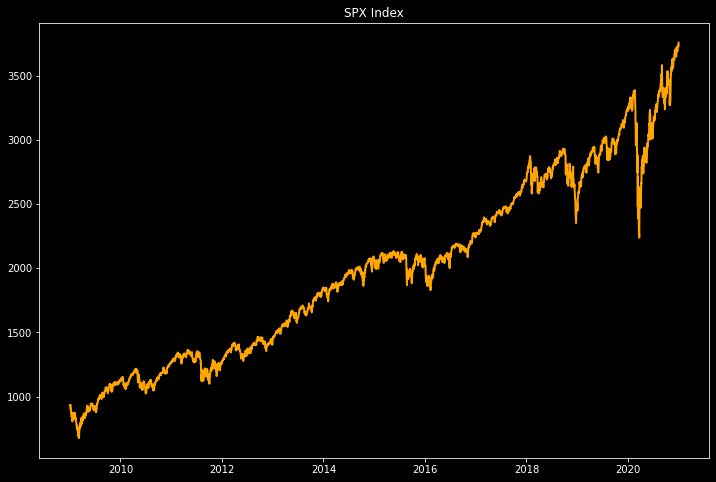

In [4]:
plt.plot(df, color='orange')
plt.title('SPX Index');

In [5]:
# calculate log return
returns = np.log(df).diff().fillna(0)
returns

Date
2009-01-02    0.000000
2009-01-05   -0.004679
2009-01-06    0.007787
2009-01-07   -0.030469
2009-01-08    0.003391
                ...   
2020-12-24    0.003530
2020-12-28    0.008685
2020-12-29   -0.002230
2020-12-30    0.001341
2020-12-31    0.006418
Name: Adj Close, Length: 3021, dtype: float64

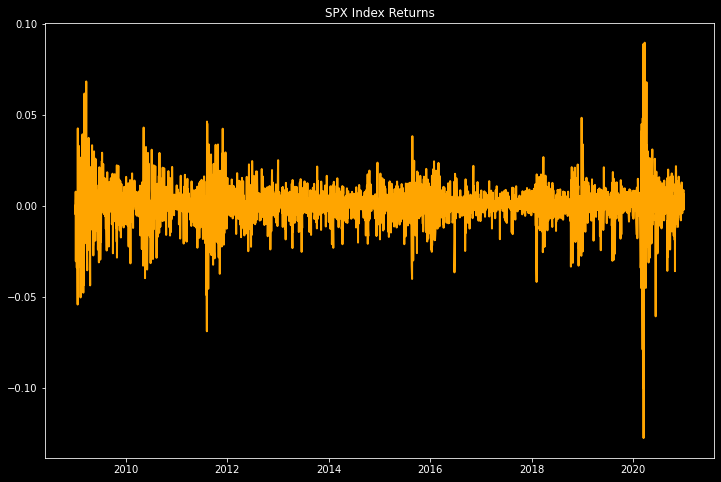

In [6]:
# visulaize returns
plt.plot(returns, color='orange')
plt.title('SPX Index Returns');

In [7]:
# GARCH(1,1) function

def garch(omega, alpha, beta, ret):
    
    var = []
    for i in range(len(ret)):
        if i==0:
            var.append(omega/np.abs(1-alpha-beta))
        else:
            var.append(omega + alpha * ret[i-1]**2 + beta * var[i-1])
            
    return np.array(var)

In [8]:
garch(np.var(returns),0.1,0.8,returns)

array([0.00136366, 0.00122729, 0.00112039, ..., 0.00069711, 0.00069455,
       0.00069219])

In [9]:
# log likelihood function

def likelihood(params, ret):
    
    omega = params[0]; alpha = params[1]; beta = params[2]
    
    variance = garch(omega, alpha, beta, ret) #GARCH(1,1)
    
    llh=[]
    for i in range(len(ret)):
        llh.append(np.log(norm.pdf(ret[i], 0, np.sqrt(variance[i]))))
    
    return -np.sum(np.array(llh))

In [10]:
likelihood((np.var(returns), 0.1, 0.8), returns)

-7881.868784195197

In [11]:
# optimization

# input
params = ['omega','alpha','beta']
initial_values = ((np.var(returns)), 0.1, 0.8) # can be 0,0,0

# opt
res = minimize(likelihood, initial_values, args = returns, method = 'Nelder-Mead', options={'disp':False})
res

 final_simplex: (array([[3.02398346e-06, 1.66716946e-01, 8.15417329e-01],
       [3.02271806e-06, 1.66787920e-01, 8.15398228e-01],
       [3.02377952e-06, 1.66744261e-01, 8.15432017e-01],
       [3.02149237e-06, 1.66710993e-01, 8.15469573e-01]]), array([-9960.80806965, -9960.80806879, -9960.8080682 , -9960.80806387]))
           fun: -9960.808069647772
       message: 'Optimization terminated successfully.'
          nfev: 244
           nit: 136
        status: 0
       success: True
             x: array([3.02398346e-06, 1.66716946e-01, 8.15417329e-01])

In [12]:
# GARCH parameters
dict(zip(params, np.around(res['x']*100,4)))

{'omega': 0.0003, 'alpha': 16.6717, 'beta': 81.5417}

In [13]:
# parameters
omega = res['x'][0]
alpha = res['x'][1]
beta = res['x'][2]

# variance
var = garch(omega, alpha, beta, returns)

# annaulized conditional volatility
ann_vol = np.sqrt(var*252)*100
ann_vol

array([20.6528341 , 18.85280309, 17.51118855, ..., 10.54680756,
       10.02060387,  9.50019167])

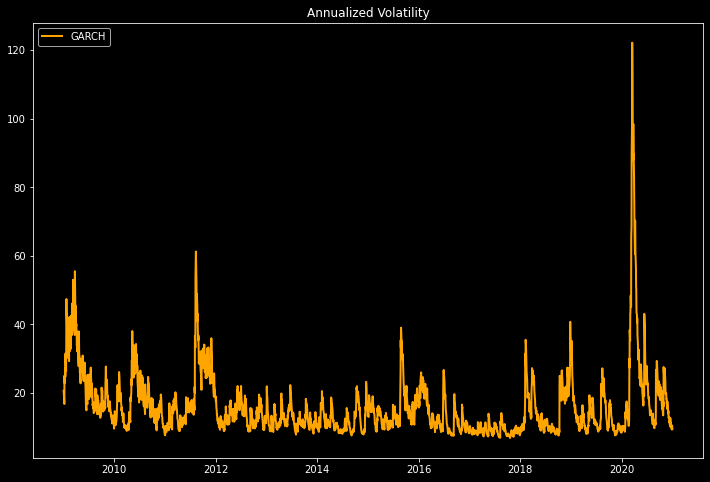

In [14]:
# Visualise GARCH volatility and VIX
plt.title('Annualized Volatility')
plt.plot(returns.index, ann_vol, color='orange', label='GARCH')
plt.legend(loc=2);

In [15]:
# N-day Forecast

# long-term variance
np.sqrt(252*omega/(1-alpha-beta))*100

20.65283410318942

In [16]:
# calculate N-day forecast
longrun_variance = omega/(1-alpha-beta)

fvar = []
for i in range(1,732):
    fvar.append(longrun_variance + (alpha+beta)**i*(var[-1] - longrun_variance))

var = np.array(fvar)

In [17]:
var[:10]

array([3.81990609e-05, 4.05405904e-05, 4.28402868e-05, 4.50988975e-05,
       4.73171565e-05, 4.94957847e-05, 5.16354900e-05, 5.37369681e-05,
       5.58009016e-05, 5.78279615e-05])

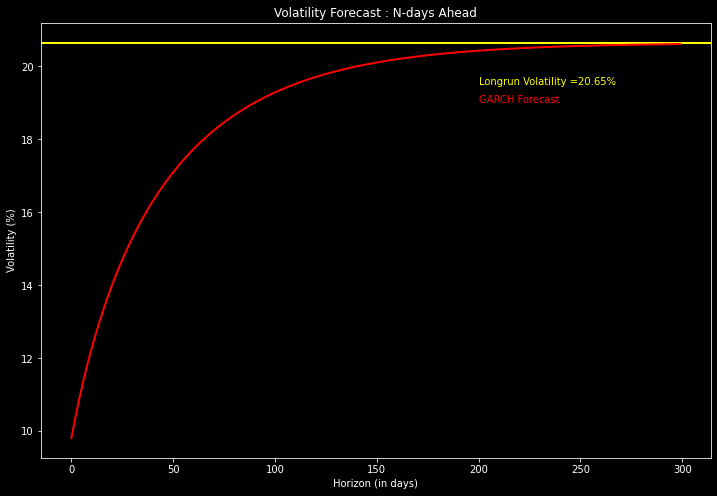

In [18]:
# Plot volatility forecast over different time horizon
plt.axhline(y=np.sqrt(longrun_variance*252)*100, color='yellow')
plt.plot(np.sqrt(var[:300]*252)*100, color='red')

plt.xlabel('Horizon (in days)')
plt.ylabel('Volatility (%)')

plt.annotate('GARCH Forecast', xy=(200,19), color='red')
plt.annotate('Longrun Volatility =' + str(np.around(np.sqrt(longrun_variance*252)*100,2)) + '%', 
             xy=(200,19.50), color='yellow')

plt.title('Volatility Forecast : N-days Ahead')
plt.grid(axis='x')

In [19]:
# import arch library
from arch import arch_model

In [20]:
# mean = 0
g1 = arch_model(returns, vol='GARCH', mean='Zero', p=1, o=0, q=1, dist='Normal')

In [21]:
# model output
model = g1.fit()
print(model)

Iteration:      1,   Func. Count:      4,   Neg. LLF: -9951.251871917915
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9951.251860572702
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
                       Zero Mean - GARCH Model Results                        
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                9951.25
Distribution:                  Normal   AIC:                          -19896.5
Method:            Maximum Likelihood   BIC:                          -19878.5
                                        No. Observations:                 3021
Date:                Sun, Mar 20 2022   Df Residuals:                     3021
Time:                        23:39:06   Df Model:                            0
         

In [22]:
model.params

omega       0.000003
alpha[1]    0.200000
beta[1]     0.780000
Name: params, dtype: float64

In [23]:
# params with confidence level
model.conf_int(alpha=0.05)

,lower,upper
omega,0.000003,0.000003
alpha[1],0.034917,0.365083
beta[1],0.664614,0.895386


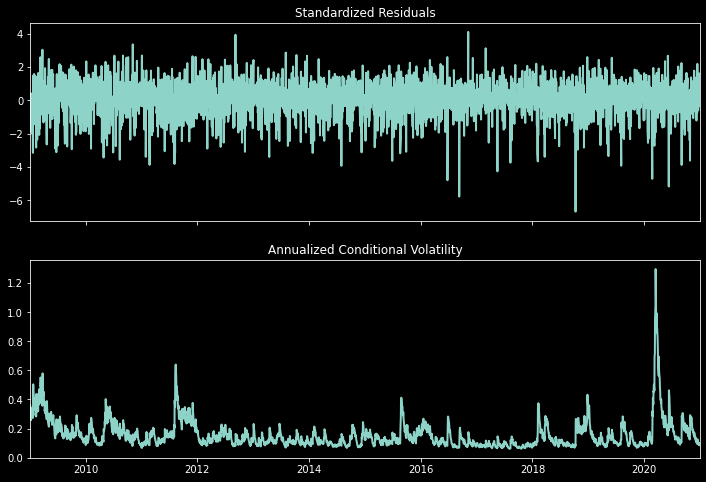

In [24]:
# plot annualized vol
fig = model.plot(annualize='D')